In [2]:
!pip install pytorch-lightning einops seaborn opencv-python omegaconf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 18.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 51.0 MB/s eta 0:00:00


## **Imports**
---

In [5]:
import sys
import os
import pytorch_lightning as pl
from omegaconf import OmegaConf

# Append the absolute path of the src directory
src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)
print("sys.path:", sys.path)

from models.ViT import ViT
from data_modules.coral_module import CoralDataModule
from utils.set_seed import set_seed
from utils.logger import (
    save_final_model_and_hparams,
    save_experiment_artifacts
)
from evaluation.visualizations import (
    plot_loss_curves,
    plot_metrics_curves,
    visualize_average_attention_maps,
    visualize_model_predictions,
    preprocess_single_image,
    plot_original_images
)
from evaluation.metrics import (
    calculate_metrics,
    evaluate_model
)

sys.path: ['/Users/sebastianwefers/Developer/Tools/conda/base/envs/ViT/lib/python39.zip', '/Users/sebastianwefers/Developer/Tools/conda/base/envs/ViT/lib/python3.9', '/Users/sebastianwefers/Developer/Tools/conda/base/envs/ViT/lib/python3.9/lib-dynload', '', '/Users/sebastianwefers/Developer/Tools/conda/base/envs/ViT/lib/python3.9/site-packages', '/Users/sebastianwefers/Developer/Tools/conda/base/envs/ViT/lib/python3.9/site-packages/setuptools/_vendor', '/Users/sebastianwefers/Desktop/Kolmogorov-Arnold-Fourier-Embeddings/src']


## **Setting Stage**
---
- Set seed:

In [6]:
set_seed(14473)

Seed set to 14473 for reproducibility.


- Set device:
  - Cuda available?

In [7]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## **EDA**
---

Class to index mapping: {'bleached_corals': 0, 'healthy_corals': 1}

Label Distributions:
   - Train set: [333 293]
   - Val set: [48 42]
   - Test set: [95 84]


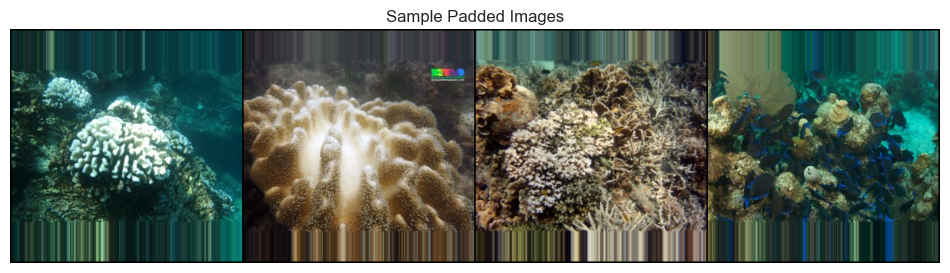

In [4]:
data_dir = '/Users/sebastianwefers/Desktop/Kolmogorov-Arnold-Fourier-Embeddings/data/coral_original'

DataModule = CoralDataModule(
        data_dir=data_dir,
        batch_size=64,
        img_size=300,
        scaler_type='min-max',
        test_size=0.2,                 # originally 0.2
        val_size=0.1,                  # originally 0.1
        num_workers=2,
        padding_mode='edge'            # Padding mode can be 'reflect' or 'edge'
)
DataModule.setup()
#data_module._verify_rgb_distribution()
DataModule._verify_class_distribution()
DataModule.display_sample_images()

## ***`Training`***
---
### **`1) MLP`**

In [ ]:
# Load the configuration from the YAML file
config_linear = OmegaConf.load("../configs/default/ViT/config_linear.yaml")
# convert to dict:
config_linear = OmegaConf.to_container(config_linear, resolve=True)
# set correct data dir:
config_linear['data']['data_dir'] = data_dir
config_linear

In [ ]:
# Example usage
data_module = CoralDataModule(
    **config_linear['data']    # Padding mode can be 'reflect' or 'edge'
)

# Call the setup method if it's not automatically called within a trainer
data_module.setup()

# Create the train dataloader and measure its length
train_loader = data_module.train_dataloader()
num_batches  = len(train_loader)
print("Number of training batches:", num_batches)

# Determine an appropriate log interval
# Here, I'm setting it to log at least once per epoch or more frequently if desired
log_every_n_steps = max(1, num_batches // 10)


# Initialize the Vision Transformer Model
ViT_linear_embedding = ViT(
    **config_linear['model']
)

# Set up the trainer
trainer = pl.Trainer(
    max_epochs=config_linear['training']['max_epochs'],       # before 30
    precision="16-mixed",
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    log_every_n_steps=log_every_n_steps
)

# Train the model
trainer.fit(
    ViT_linear_embedding,
    datamodule=data_module
)

In [ ]:
# Example usage
data_module = CoralDataModule(
    **config_linear['data']    # Padding mode can be 'reflect' or 'edge'
)

# Call the setup method if it's not automatically called within a trainer
data_module.setup()

# Create the train dataloader and measure its length
train_loader = data_module.train_dataloader()
num_batches  = len(train_loader)
print("Number of training batches:", num_batches)

# Determine an appropriate log interval
# Here, I'm setting it to log at least once per epoch or more frequently if desired
log_every_n_steps = max(1, num_batches // 10)


# Initialize the Vision Transformer Model
ViT_linear_embedding = ViT(
    **config_linear['model']
)

# Set up the trainer
trainer = pl.Trainer(
    max_epochs=config_linear['training']['max_epochs'],       # before 30
    precision="16-mixed",
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    log_every_n_steps=log_every_n_steps
)

# Train the model
trainer.fit(
    ViT_linear_embedding,
    datamodule=data_module
)

In [ ]:
plot_metrics_curves(ViT_linear_embedding)

In [ ]:
trainer.test(ViT_linear_embedding, datamodule=DataModule)

In [ ]:
save_experiment_artifacts(
    config=config_linear,
    model=ViT_linear_embedding,
    model_type='ViT',
    embedding_type='linear',
    data_module_config = config_linear["data"],
    trainer_config = config_linear['training']
)

In [14]:
import os
import yaml
import torch
import pytorch_lightning as pl

# -----------------------------
# Step 1: Set the experiment directory.
# -----------------------------
# You should choose the directory corresponding to the experiment you want to load.
# For example, if you saved your experiment artifacts under:
# "../configs/experiments/ViT/linear/<unique_id>"
experiment_dir = "../configs/experiments/ViT/linear/20250207_145446"  # change this to your unique folder

# -----------------------------
# Step 2: Load the unified configuration.
# -----------------------------
config_path = os.path.join(experiment_dir, "config.yaml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

# Optionally, load split configurations if needed:
# data_module_config = yaml.safe_load(open(os.path.join(experiment_dir, "data_module_config.yaml"), "r"))
# trainer_config = yaml.safe_load(open(os.path.join(experiment_dir, "trainer_config.yaml"), "r"))


model_params = config["model"]

# Example: Create a new instance of the model using parameters from config.
model = ViT(
    img_size=model_params.get("img_size", 300),  # You can provide defaults if needed.
    patch_size=model_params["patch_size"],
    in_channels=model_params["in_channels"],
    embed_size=model_params["embed_size"],
    depth=model_params["depth"],
    heads=model_params["heads"],
    mlp_dim=model_params["mlp_dim"],
    dropout=model_params["dropout"],
    learning_rate=model_params["learning_rate"],
    embedding_type=model_params["embedding_type"],
    fourier_params=model_params.get("fourier_params", None)
)

# -----------------------------
# Step 4: Load the saved model weights.
# -----------------------------
checkpoint_path = os.path.join(experiment_dir, "model_weights.ckpt")
state_dict = torch.load(checkpoint_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(state_dict)
print(f"Loaded model weights from {checkpoint_path}")


data_module_config = config["data"]
data_module_config["data_dir"] = "../data/all_data"
data_module = CoralDataModule(**data_module_config)
data_module.setup()

# Set up the trainer
trainer = pl.Trainer(
    max_epochs=config['training']['max_epochs'],       # before 30
    precision="16-mixed",
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    #log_every_n_steps=log_every_n_steps
)

# Run testing/inference.
test_results = trainer.test(model, datamodule=data_module)
print("Test results:", test_results)

Loaded model weights from ../configs/experiments/ViT/linear/20250207_145446/model_weights.ckpt
Class to index mapping: {'bleached': 0, 'healthy': 1}


/Users/sebastianwefers/Developer/Tools/conda/base/envs/ViT/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:513: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sebastianwefers/Developer/Tools/conda/base/envs/ViT/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable Ten

Class to index mapping: {'bleached': 0, 'healthy': 1}
Testing DataLoader 0:  57%|█████▋    | 89/155 [07:07<05:17,  0.21it/s]

In [12]:


# Example usage with four images
image_paths = [
    'coral_original/healthy_corals/10472474274_1f73391912_o.jpg',
    'coral_original/healthy_corals/12618485353_670ca1b648_o.jpg',
    'coral_original/bleached_corals/25382194631_baca94f8a8_o.jpg',
    'attention_map_pics/attentionmap_example.jpg'
]

# Preprocess all four images
processed_images = [preprocess_single_image(image_path, img_size=300, padding_mode='edge') for image_path in image_paths]

# Plot the original images
plot_original_images(processed_images)
# Visualize the attention maps
visualize_average_attention_maps(model, processed_images)

'/Users/sebastianwefers/Desktop/Kolmogorov-Arnold-Fourier-Embeddings/notebooks'

### **`2) Conv`**

In [ ]:
data_module = CoralDataModule(
        data_dir=data_dir, 
        batch_size=12,    
        img_size=300, 
        scaler_type='min-max', 
        test_size=0.2, 
        val_size=0.2, 
        num_workers=2,
        padding_mode='edge'           
)

# Call the setup method if it's not automatically called within a trainer
data_module.setup()

# Create the train dataloader and measure its length
train_loader = data_module.train_dataloader()
num_batches = len(train_loader)
print("Number of training batches:", num_batches)

# Determine an appropriate log interval
# Here, I'm setting it to log at least once per epoch or more frequently if desired
log_every_n_steps = max(1, num_batches // 10)

# Initialize the Vision Transformer Model
ViT_conv_embedding = ViT(
    img_size=300,
    patch_size=16,      #16
    in_channels=3,
    embed_size=66,      #64    #66 worked well aslo
    depth=2,            #2       
    heads=3,            #2     # 3 wokred well also
    mlp_dim=128,        #128
    dropout=0.2,        #2
    learning_rate=1e-4, #1e-4              
    embedding_type='conv',
)



# Set up the trainer
trainer = pl.Trainer(
    max_epochs=30,       # before 30
    precision="16-mixed",
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    log_every_n_steps=log_every_n_steps
)

# Train the model
trainer.fit(ViT_conv_embedding, datamodule=data_module)

In [ ]:
trainer.test(ViT_conv_embedding, datamodule=DataModule)

### **`3) KAN_Fourier`**

In [ ]:
data_module = CoralDataModule(
        data_dir=data_dir, 
        batch_size=10,          # 10
        scaler_type='pi-scale',
        img_size=300, 
        test_size=0.2, 
        val_size=0.2, 
        num_workers=2,
        padding_mode='edge'    # edge         # Padding mode can be 'reflect' or 'edge'
)

# Call the setup method if it's not automatically called within a trainer
data_module.setup()

# Create the train dataloader and measure its length
train_loader = data_module.train_dataloader()
num_batches  = len(train_loader)
print("Number of training batches:", num_batches)

# Determine an appropriate log interval
# Here, I'm setting it to log at least once per epoch or more frequently if desired
log_every_n_steps = max(1, num_batches // 10)


# Set Fourier-specific parameters
fourier_params = {
    'gridsize': 8,                  # 8
    'addbias': True,                # True
    'smooth_initialization': False  # False
}

# Initialize the Vision Transformer Model
ViT_fourier_embedding = ViT(
    img_size=300,
    patch_size=10,     # 10
    in_channels=3,
    embed_size=64,     # 64
    depth=2,           #  2
    heads=2,           #  2
    mlp_dim=128,       #128
    dropout=0.1,       # 0.1
    learning_rate=1e-5,# 1e-5               # before 1e-3 ---> 1e-5 made loss curves better ; 1e-4 really bad as well
    embedding_type='fourier',             # ///--> 1e-6 shows beautifull loss curves but model does not get great perfromance after 50 epochs
    fourier_params=fourier_params
)



# Set up the trainer
trainer = pl.Trainer(
    max_epochs=30,       # before 30
    precision="16-mixed",
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    log_every_n_steps=log_every_n_steps
)

# Train the model
trainer.fit(ViT_fourier_embedding, datamodule=data_module)

In [ ]:
trainer.test(ViT_fourier_embedding, datamodule=DataModule)